In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((400, 400)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=25088, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.vgg16(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 14815044


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


train loss:  0.12296492965239851
Val loss:  0.1245997086815212
train accuracy:  0.5754352030947776
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 5.655 minutes. Time expected till completion: 559.850 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


train loss:  0.11200228434351472
Val loss:  0.12899384498596192
train accuracy:  0.6121856866537717
Val accuracy:  0.5478260869565217
Current time: 9.261 minutes. Time expected till completion: 453.807 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


train loss:  0.10473276131445942
Val loss:  0.11818665628847869
train accuracy:  0.6411992263056093
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 12.862 minutes. Time expected till completion: 415.873 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


train loss:  0.10242671866827362
Val loss:  0.12296148538589477
train accuracy:  0.620889748549323
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 16.464 minutes. Time expected till completion: 395.134 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train loss:  0.09981001524445628
Val loss:  0.12375451870586561
train accuracy:  0.6373307543520309
Val accuracy:  0.5652173913043478
Current time: 20.073 minutes. Time expected till completion: 381.387 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train loss:  0.09551347639390072
Val loss:  0.1097456271233766
train accuracy:  0.6547388781431335
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 23.688 minutes. Time expected till completion: 371.107 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.09478849841270963
Val loss:  0.1164255924846815
train accuracy:  0.6499032882011605
Val accuracy:  0.5391304347826087
Current time: 27.310 minutes. Time expected till completion: 362.834 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.09169615767680007
Val loss:  0.13428689707880434
train accuracy:  0.683752417794971
Val accuracy:  0.5565217391304348
Current time: 30.959 minutes. Time expected till completion: 356.025 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train loss:  0.08946532575950401
Val loss:  0.1256129643191462
train accuracy:  0.6827852998065764
Val accuracy:  0.5478260869565217
Current time: 34.653 minutes. Time expected till completion: 350.381 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train loss:  0.08614609203151855
Val loss:  0.12260926599087922
train accuracy:  0.6934235976789168
Val accuracy:  0.5652173913043478
Current time: 38.346 minutes. Time expected till completion: 345.112 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.08312171967105662
Val loss:  0.1469539857429007
train accuracy:  0.7127659574468085
Val accuracy:  0.5739130434782609
Current time: 42.032 minutes. Time expected till completion: 340.079 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.08389890157911256
Val loss:  0.1349676663460939
train accuracy:  0.7117988394584139
Val accuracy:  0.5652173913043478
Current time: 45.716 minutes. Time expected till completion: 335.253 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.08033072101078366
Val loss:  0.1797851690131685
train accuracy:  0.7214700193423598
Val accuracy:  0.5478260869565217
Current time: 49.407 minutes. Time expected till completion: 330.645 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.07768523778110685
Val loss:  0.1432576270207115
train accuracy:  0.7485493230174082
Val accuracy:  0.48695652173913045
Current time: 53.094 minutes. Time expected till completion: 326.149 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train loss:  0.07497874586851962
Val loss:  0.1264236991820128
train accuracy:  0.7388781431334622
Val accuracy:  0.5565217391304348
Current time: 56.773 minutes. Time expected till completion: 321.715 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.07245661180675375
Val loss:  0.16729736898256384
train accuracy:  0.7446808510638298
Val accuracy:  0.5130434782608696
Current time: 60.445 minutes. Time expected till completion: 317.334 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.07229627484394457
Val loss:  0.13569749645564866
train accuracy:  0.7553191489361702
Val accuracy:  0.4956521739130435
Current time: 64.116 minutes. Time expected till completion: 313.038 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.06975986789083342
Val loss:  0.2058904036231663
train accuracy:  0.7649903288201161
Val accuracy:  0.4260869565217391
Current time: 67.777 minutes. Time expected till completion: 308.763 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.06548892872361196
Val loss:  0.14021265092103377
train accuracy:  0.7717601547388782
Val accuracy:  0.4782608695652174
Current time: 71.427 minutes. Time expected till completion: 304.502 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.06368619060356394
Val loss:  0.1387854700503142
train accuracy:  0.7872340425531915
Val accuracy:  0.5565217391304348
Current time: 75.063 minutes. Time expected till completion: 300.250 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.06057964570863565
Val loss:  0.17171869277954102
train accuracy:  0.7998065764023211
Val accuracy:  0.5652173913043478
Current time: 78.713 minutes. Time expected till completion: 296.112 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.06306970579913553
Val loss:  0.14468601708826812
train accuracy:  0.804642166344294
Val accuracy:  0.5217391304347826
Current time: 82.351 minutes. Time expected till completion: 291.970 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.057083867771309624
Val loss:  0.17418756847796232
train accuracy:  0.811411992263056
Val accuracy:  0.5043478260869565
Current time: 85.984 minutes. Time expected till completion: 287.860 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.05333914171104505
Val loss:  0.161837159032407
train accuracy:  0.8181818181818182
Val accuracy:  0.5565217391304348
Current time: 89.624 minutes. Time expected till completion: 283.810 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.05868531289425763
Val loss:  0.14810786687809488
train accuracy:  0.8007736943907157
Val accuracy:  0.5130434782608696
Current time: 93.261 minutes. Time expected till completion: 279.782 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.05251084035352535
Val loss:  0.1525676576987557
train accuracy:  0.8249516441005803
Val accuracy:  0.5217391304347826
Current time: 96.904 minutes. Time expected till completion: 275.805 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.05204006637909542
Val loss:  0.1667074794354646
train accuracy:  0.8230174081237911
Val accuracy:  0.5217391304347826
Current time: 100.554 minutes. Time expected till completion: 271.868 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.04849228325589944
Val loss:  0.1999762016793956
train accuracy:  0.8500967117988395
Val accuracy:  0.4956521739130435
Current time: 104.211 minutes. Time expected till completion: 267.971 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.04437810120693403
Val loss:  0.18538767876832382
train accuracy:  0.8568665377176016
Val accuracy:  0.5391304347826087
Current time: 107.870 minutes. Time expected till completion: 264.096 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


train loss:  0.04276021682014203
Val loss:  0.18094874231711677
train accuracy:  0.8704061895551257
Val accuracy:  0.48695652173913045
Current time: 111.530 minutes. Time expected till completion: 260.237 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.04087934004975126
Val loss:  0.20478486885195193
train accuracy:  0.874274661508704
Val accuracy:  0.5217391304347826
Current time: 115.184 minutes. Time expected till completion: 256.376 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.04030958380787931
Val loss:  0.19828983363897904
train accuracy:  0.8713733075435203
Val accuracy:  0.5478260869565217
Current time: 118.828 minutes. Time expected till completion: 252.508 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.03945100977494448
Val loss:  0.23026258116183074
train accuracy:  0.8694390715667312
Val accuracy:  0.5478260869565217
Current time: 122.461 minutes. Time expected till completion: 248.633 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.03778400602687431
Val loss:  0.213366334852965
train accuracy:  0.8771760154738878
Val accuracy:  0.5304347826086957
Current time: 126.095 minutes. Time expected till completion: 244.773 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.03561103231196131
Val loss:  0.26259313744047413
train accuracy:  0.8926499032882012
Val accuracy:  0.43478260869565216
Current time: 129.733 minutes. Time expected till completion: 240.933 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.03644717081559811
Val loss:  0.20864366552104122
train accuracy:  0.8955512572533849
Val accuracy:  0.5565217391304348
Current time: 133.359 minutes. Time expected till completion: 237.082 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.035567209019183366
Val loss:  0.23801311060138372
train accuracy:  0.8849129593810445
Val accuracy:  0.5217391304347826
Current time: 136.978 minutes. Time expected till completion: 233.233 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.033148094824365766
Val loss:  0.19040209832398788
train accuracy:  0.8955512572533849
Val accuracy:  0.5565217391304348
Current time: 140.612 minutes. Time expected till completion: 229.419 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.030007966255455692
Val loss:  0.21966778506403384
train accuracy:  0.9110251450676983
Val accuracy:  0.5130434782608696
Current time: 144.233 minutes. Time expected till completion: 225.595 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.029494923256640278
Val loss:  0.24986821283464847
train accuracy:  0.9168278529980658
Val accuracy:  0.4956521739130435
Current time: 147.853 minutes. Time expected till completion: 221.779 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.026280543328275476
Val loss:  0.23899855354557867
train accuracy:  0.9197292069632496
Val accuracy:  0.5391304347826087
Current time: 151.471 minutes. Time expected till completion: 217.970 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.034742773306957755
Val loss:  0.27974332571029664
train accuracy:  0.8936170212765957
Val accuracy:  0.48695652173913045
Current time: 155.088 minutes. Time expected till completion: 214.169 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.024866653797694083
Val loss:  0.2595346165739972
train accuracy:  0.9197292069632496
Val accuracy:  0.4608695652173913
Current time: 158.717 minutes. Time expected till completion: 210.393 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.02690146830832726
Val loss:  0.23861050502113673
train accuracy:  0.9197292069632496
Val accuracy:  0.5217391304347826
Current time: 162.354 minutes. Time expected till completion: 206.633 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.01727138800596966
Val loss:  0.2889010864755382
train accuracy:  0.9535783365570599
Val accuracy:  0.5478260869565217
Current time: 166.009 minutes. Time expected till completion: 202.900 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.02036084455295648
Val loss:  0.28128672527230303
train accuracy:  0.9477756286266924
Val accuracy:  0.5565217391304348
Current time: 169.700 minutes. Time expected till completion: 199.213 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.025337249086989626
Val loss:  0.2757048311440841
train accuracy:  0.9332688588007737
Val accuracy:  0.5391304347826087
Current time: 173.383 minutes. Time expected till completion: 195.517 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train loss:  0.02170657193129684
Val loss:  0.2816019231858461
train accuracy:  0.9477756286266924
Val accuracy:  0.46956521739130436
Current time: 177.071 minutes. Time expected till completion: 191.827 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.02812505342409454
Val loss:  0.2765209669652193
train accuracy:  0.925531914893617
Val accuracy:  0.45217391304347826
Current time: 180.751 minutes. Time expected till completion: 188.129 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.024676449547118257
Val loss:  0.26825864159542584
train accuracy:  0.9410058027079303
Val accuracy:  0.4608695652173913
Current time: 184.425 minutes. Time expected till completion: 184.425 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.01443915503273846
Val loss:  0.27364656044089275
train accuracy:  0.9632495164410058
Val accuracy:  0.5478260869565217
Current time: 188.104 minutes. Time expected till completion: 180.727 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.015105446301095775
Val loss:  0.30667008990826816
train accuracy:  0.960348162475822
Val accuracy:  0.4782608695652174
Current time: 191.769 minutes. Time expected till completion: 177.018 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.02097142830840537
Val loss:  0.2905194702355758
train accuracy:  0.9516441005802708
Val accuracy:  0.5043478260869565
Current time: 195.427 minutes. Time expected till completion: 173.303 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.011557874310202356
Val loss:  0.3035350063572759
train accuracy:  0.9671179883945842
Val accuracy:  0.48695652173913045
Current time: 199.084 minutes. Time expected till completion: 169.590 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.013151216559266092
Val loss:  0.5420195911241614
train accuracy:  0.9661508704061895
Val accuracy:  0.4608695652173913
Current time: 202.733 minutes. Time expected till completion: 165.873 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.01408529509315686
Val loss:  0.34528336162152495
train accuracy:  0.9642166344294004
Val accuracy:  0.4956521739130435
Current time: 206.367 minutes. Time expected till completion: 162.145 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.014174443344661931
Val loss:  0.3753030403800633
train accuracy:  0.960348162475822
Val accuracy:  0.4782608695652174
Current time: 210.002 minutes. Time expected till completion: 158.422 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.013574788227262574
Val loss:  0.3531856018563975
train accuracy:  0.960348162475822
Val accuracy:  0.45217391304347826
Current time: 213.633 minutes. Time expected till completion: 154.700 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.015177572108847962
Val loss:  0.33517384995584903
train accuracy:  0.9584139264990329
Val accuracy:  0.4782608695652174
Current time: 217.264 minutes. Time expected till completion: 150.980 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.016573231949142633
Val loss:  0.31986118399578595
train accuracy:  0.9622823984526112
Val accuracy:  0.4434782608695652
Current time: 220.892 minutes. Time expected till completion: 147.261 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.007334069506494001
Val loss:  0.35483406497084574
train accuracy:  0.9825918762088974
Val accuracy:  0.5478260869565217
Current time: 224.544 minutes. Time expected till completion: 143.561 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


train loss:  0.006081239978030862
Val loss:  0.4098932597948157
train accuracy:  0.9864603481624759
Val accuracy:  0.4260869565217391
Current time: 228.201 minutes. Time expected till completion: 139.865 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.010610496686608035
Val loss:  0.35944093465805055
train accuracy:  0.9700193423597679
Val accuracy:  0.5304347826086957
Current time: 231.887 minutes. Time expected till completion: 136.188 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.005773193564641896
Val loss:  0.33003145093503206
train accuracy:  0.9864603481624759
Val accuracy:  0.5043478260869565
Current time: 235.555 minutes. Time expected till completion: 132.500 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.020330335317892013
Val loss:  0.32838806224905925
train accuracy:  0.9429400386847195
Val accuracy:  0.45217391304347826
Current time: 239.228 minutes. Time expected till completion: 128.815 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train loss:  0.011845326377844485
Val loss:  0.3241805216540461
train accuracy:  0.9777562862669246
Val accuracy:  0.5130434782608696
Current time: 242.901 minutes. Time expected till completion: 125.131 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.004158143098314387
Val loss:  0.36314534622689953
train accuracy:  0.9912959381044487
Val accuracy:  0.5043478260869565
Current time: 246.575 minutes. Time expected till completion: 121.447 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.006240551646430013
Val loss:  0.3669934765152309
train accuracy:  0.9864603481624759
Val accuracy:  0.5217391304347826
Current time: 250.241 minutes. Time expected till completion: 117.761 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.020146544881597814
Val loss:  0.3114814716836681
train accuracy:  0.9535783365570599
Val accuracy:  0.46956521739130436
Current time: 253.898 minutes. Time expected till completion: 114.070 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.006083901997811451
Val loss:  0.33424869620281716
train accuracy:  0.9864603481624759
Val accuracy:  0.46956521739130436
Current time: 257.552 minutes. Time expected till completion: 110.380 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.006717036122023182
Val loss:  0.34316421436226885
train accuracy:  0.9816247582205029
Val accuracy:  0.5043478260869565
Current time: 261.211 minutes. Time expected till completion: 106.692 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.003433607170531741
Val loss:  0.39820886487546175
train accuracy:  0.9903288201160542
Val accuracy:  0.4608695652173913
Current time: 264.854 minutes. Time expected till completion: 102.999 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.00681934993402382
Val loss:  0.3521090519816979
train accuracy:  0.9835589941972921
Val accuracy:  0.43478260869565216
Current time: 268.492 minutes. Time expected till completion: 99.305 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.014810278439670045
Val loss:  0.32498995065689085
train accuracy:  0.9555125725338491
Val accuracy:  0.5304347826086957
Current time: 272.128 minutes. Time expected till completion: 95.612 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.007349174388746776
Val loss:  0.33928472270136295
train accuracy:  0.9854932301740812
Val accuracy:  0.5391304347826087
Current time: 275.759 minutes. Time expected till completion: 91.920 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0075745263464073575
Val loss:  0.3258642134459122
train accuracy:  0.9796905222437138
Val accuracy:  0.4782608695652174
Current time: 279.384 minutes. Time expected till completion: 88.227 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.003079629363919963
Val loss:  0.3510080531887386
train accuracy:  0.9922630560928434
Val accuracy:  0.5043478260869565
Current time: 283.011 minutes. Time expected till completion: 84.536 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.0018548558989977257
Val loss:  0.3931087017059326
train accuracy:  0.9980657640232108
Val accuracy:  0.5304347826086957
Current time: 286.642 minutes. Time expected till completion: 80.848 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.001987816875507334
Val loss:  0.3920474788416987
train accuracy:  0.9980657640232108
Val accuracy:  0.5391304347826087
Current time: 290.285 minutes. Time expected till completion: 77.164 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.0008467460455071984
Val loss:  0.3912722743075827
train accuracy:  0.9990328820116054
Val accuracy:  0.5043478260869565
Current time: 293.924 minutes. Time expected till completion: 73.481 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.0023841459590565797
Val loss:  0.4193338228308636
train accuracy:  0.9970986460348162
Val accuracy:  0.46956521739130436
Current time: 297.566 minutes. Time expected till completion: 69.799 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train loss:  0.0022406562549071524
Val loss:  0.40570633929708727
train accuracy:  0.9932301740812379
Val accuracy:  0.4260869565217391
Current time: 301.201 minutes. Time expected till completion: 66.117 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.018925477969919547
Val loss:  0.3362196797909944
train accuracy:  0.9516441005802708
Val accuracy:  0.4956521739130435
Current time: 304.829 minutes. Time expected till completion: 62.435 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.002798472228167287
Val loss:  0.39448405867037567
train accuracy:  0.9932301740812379
Val accuracy:  0.46956521739130436
Current time: 308.454 minutes. Time expected till completion: 58.753 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.006022999308694245
Val loss:  0.3843089399130448
train accuracy:  0.9854932301740812
Val accuracy:  0.48695652173913045
Current time: 312.079 minutes. Time expected till completion: 55.073 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.002202988959049032
Val loss:  0.41908498225004776
train accuracy:  0.9970986460348162
Val accuracy:  0.46956521739130436
Current time: 315.704 minutes. Time expected till completion: 51.394 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.001475293045073343
Val loss:  0.4082434778628142
train accuracy:  0.9980657640232108
Val accuracy:  0.4956521739130435
Current time: 319.330 minutes. Time expected till completion: 47.716 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0018339832112874135
Val loss:  0.4245361556177554
train accuracy:  0.9970986460348162
Val accuracy:  0.45217391304347826
Current time: 322.946 minutes. Time expected till completion: 44.038 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0077251760294899385
Val loss:  0.39517918565998905
train accuracy:  0.9796905222437138
Val accuracy:  0.48695652173913045
Current time: 326.559 minutes. Time expected till completion: 40.361 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.005583560885926957
Val loss:  0.3774628120919932
train accuracy:  0.988394584139265
Val accuracy:  0.4956521739130435
Current time: 330.176 minutes. Time expected till completion: 36.686 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.001148045258206565
Val loss:  0.41753716987112294
train accuracy:  0.9980657640232108
Val accuracy:  0.5043478260869565
Current time: 333.788 minutes. Time expected till completion: 33.012 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train loss:  0.0006608399553552672
Val loss:  0.4287858745326167
train accuracy:  0.9990328820116054
Val accuracy:  0.4782608695652174
Current time: 337.407 minutes. Time expected till completion: 29.340 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.001458255967473304
Val loss:  0.5267903721850852
train accuracy:  0.9961315280464217
Val accuracy:  0.4956521739130435
Current time: 341.023 minutes. Time expected till completion: 25.668 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.002781216804550288
Val loss:  0.43692425800406415
train accuracy:  0.9922630560928434
Val accuracy:  0.4782608695652174
Current time: 344.639 minutes. Time expected till completion: 21.998 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.0005332030654195334
Val loss:  0.4310030045716659
train accuracy:  1.0
Val accuracy:  0.4782608695652174
Current time: 348.264 minutes. Time expected till completion: 18.330 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0013251714179493515
Val loss:  0.4508315501005753
train accuracy:  0.9980657640232108
Val accuracy:  0.4608695652173913
Current time: 351.882 minutes. Time expected till completion: 14.662 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train loss:  0.00028823161393442176
Val loss:  0.4666919832644255
train accuracy:  1.0
Val accuracy:  0.48695652173913045
Current time: 355.498 minutes. Time expected till completion: 10.995 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0005036674733119721
Val loss:  0.46532453298568727
train accuracy:  0.9990328820116054
Val accuracy:  0.48695652173913045
Current time: 359.118 minutes. Time expected till completion: 7.329 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train loss:  0.0007140727226255411
Val loss:  0.46089453386223833
train accuracy:  0.9990328820116054
Val accuracy:  0.48695652173913045
Current time: 362.731 minutes. Time expected till completion: 3.664 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


train loss:  0.0008355392062178237
Val loss:  0.4525932052861089
train accuracy:  0.9990328820116054
Val accuracy:  0.5043478260869565
Saving model 2 checkpoint


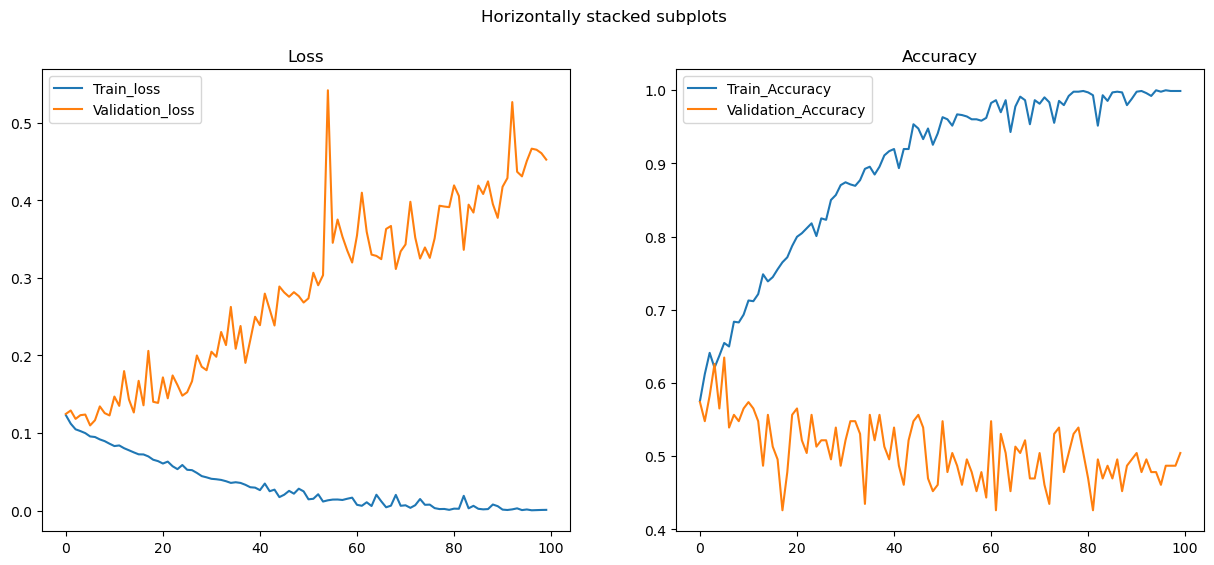

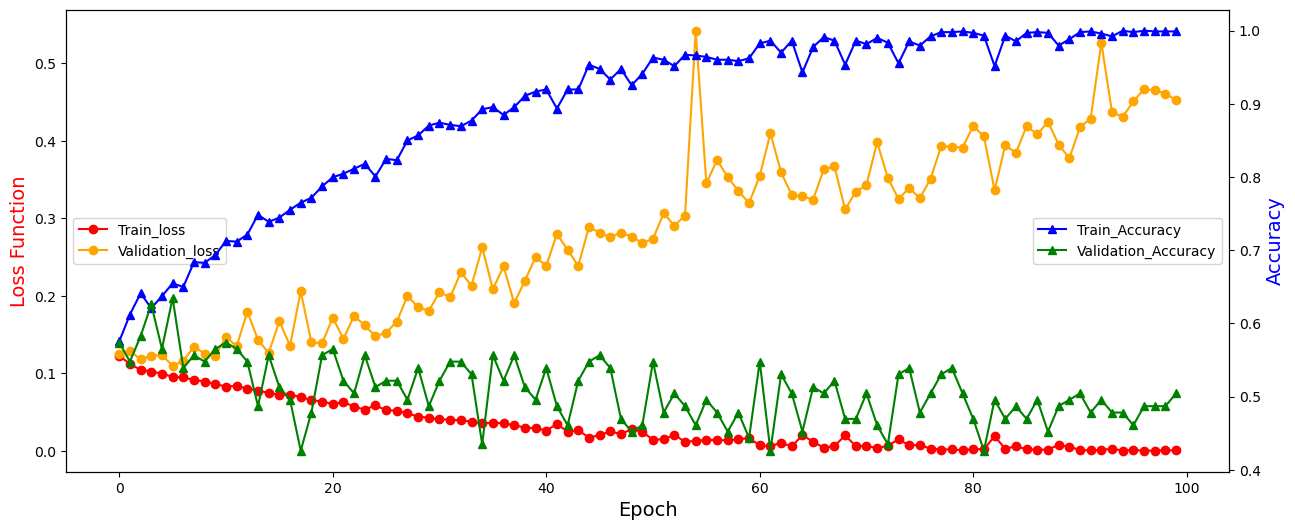

Current time: 367.181 minutes. Time expected till completion: 0.000 minutes
Finished training in: 367.181 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6347826086956522

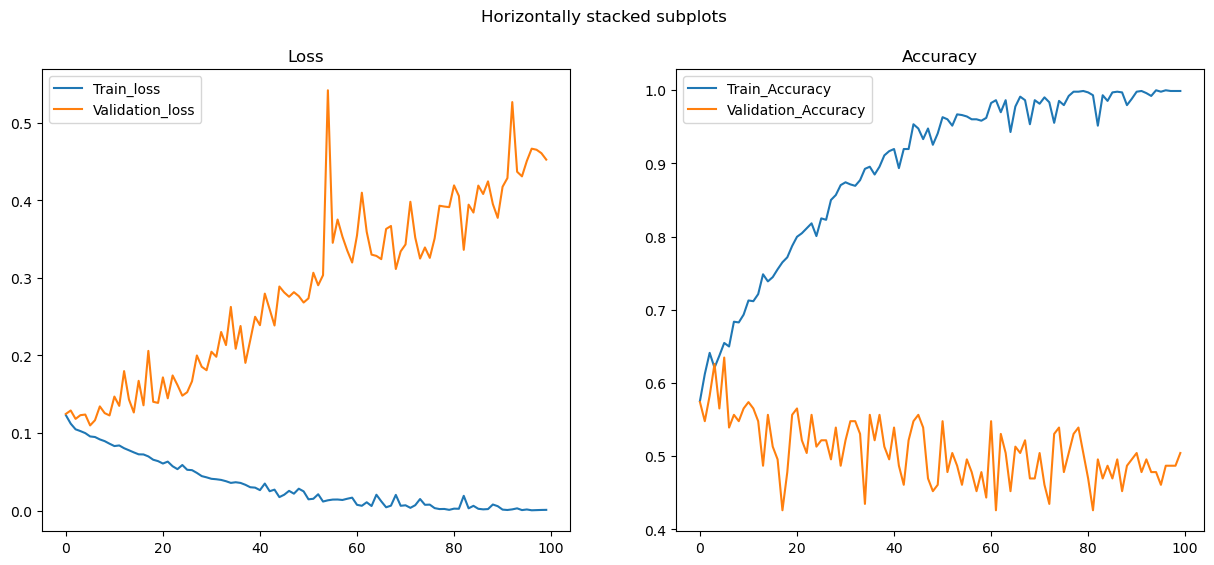

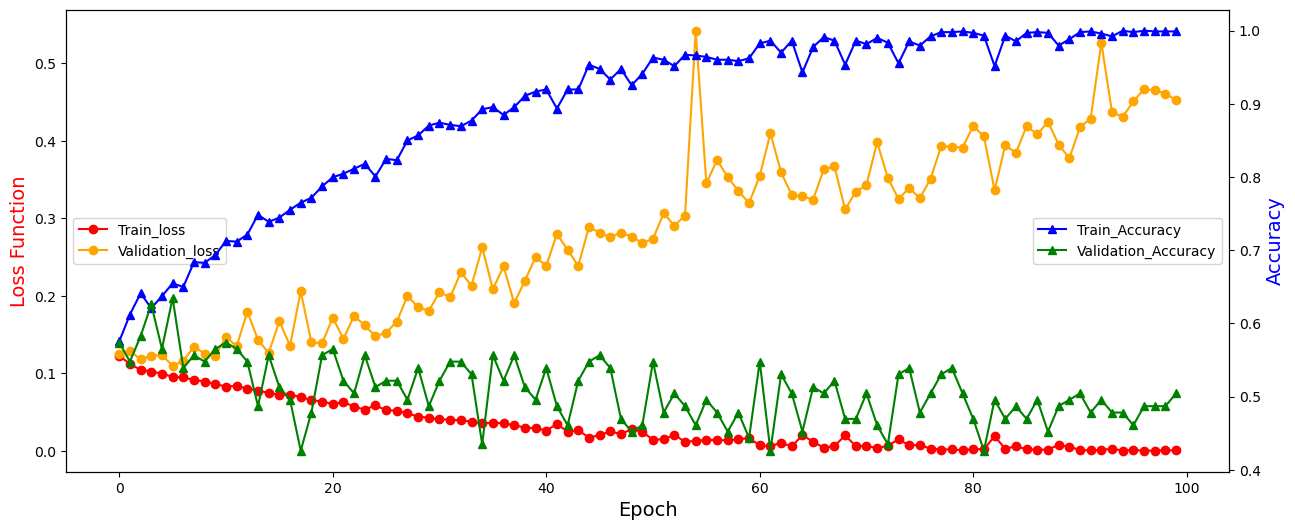

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Accuracy of the network on the 1034 Train instances: 99.80657640232108%


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

Accuracy of the network on the 115 Validation instances: 50.43478260869565%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:38<00:00,  9.88it/s]


(array([0, 1, 2, 3]), array([167, 155,  55,   3], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_VGG16_prediction.csv")

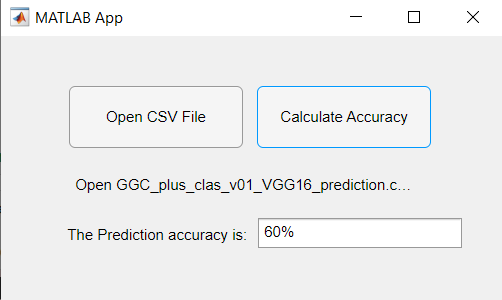

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Accuracy of the network on the 1034 Train instances: 67.02127659574468%


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

Accuracy of the network on the 115 Validation instances: 63.47826086956522%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:34<00:00, 11.07it/s]


(array([0, 1, 2]), array([159, 128,  93], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_VGG16_best_prediction.csv")

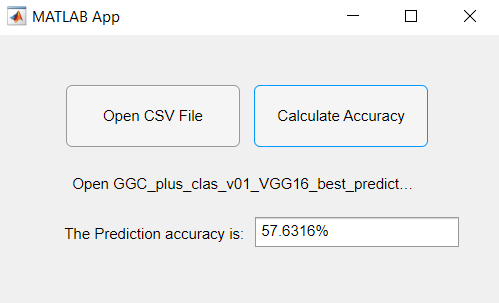